In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ultralytics

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rzc8sh51
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rzc8sh51
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=dbe1557d84a5f3e2b283f4bfa70cfbb58fec04c079cabcbe4c6df1367ee888a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v21s44g/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 45.4 MB/s eta 0:00:00


Detected Condition: a person wearing green clothes
Confidence Scores: [[0.9844  0.01567]]


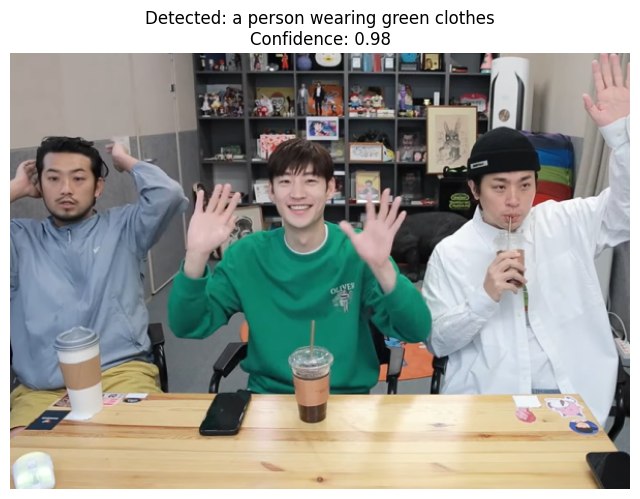

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

# 1. CLIP 모델 로드 및 텍스트 프롬프트
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

image_path = "ex.png"  # 이미지 경로
image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
text_prompts = ["a person wearing green clothes", "a person wearing red clothes"]

# CLIP 텍스트-이미지 매칭
text_inputs = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text_inputs)
    logits_per_image, logits_per_text = clip_model(image, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# 가장 높은 유사도를 가진 텍스트
detected_prompt = text_prompts[np.argmax(probs)]
print(f"Detected Condition: {detected_prompt}")
print(f"Confidence Scores: {probs}")

# 2. 이미지와 결과 시각화
original_image = Image.open(image_path).convert("RGB")

# 시각화
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f"Detected: {detected_prompt}\nConfidence: {probs.max():.2f}")
plt.axis("off")
plt.show()


image 1/1 /content/ex3.jpg: 448x640 3 cups, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


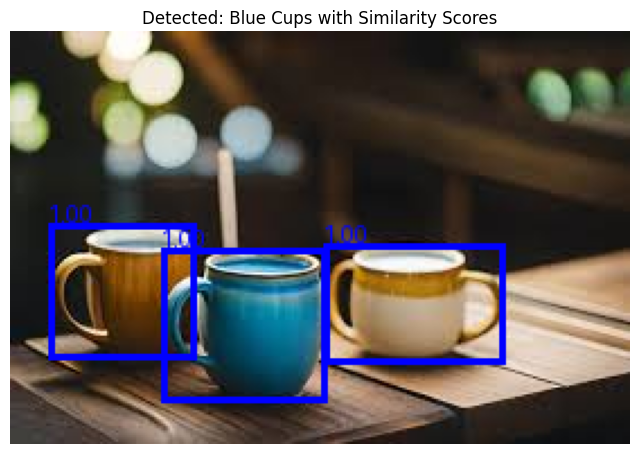

In [ ]:
import torch
import clip
from PIL import Image, ImageDraw
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. CLIP 및 YOLO 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
yolo_model = YOLO("yolov8n.pt")  # YOLOv8 Nano 모델 사용

# 2. 이미지 로드
image_path = "ex3.jpg"  # 분석할 이미지 경로
original_image = Image.open(image_path).convert("RGB")

# 3. YOLO로 "컵" 객체 탐지
results = yolo_model.predict(image_path, conf=0.5)  # Confidence Threshold: 0.5
boxes = []  # "cup" 클래스만 저장

for result in results[0].boxes:
    if result.cls == 41:  # COCO 클래스 ID 41: "cup"
        boxes.append(result.xyxy.cpu().numpy().astype(int).tolist()[0])  # [x_min, y_min, x_max, y_max]

# 4. CLIP으로 텍스트 프롬프트와 매칭
prompt = "a blue cup"  # 판별할 텍스트 프롬프트
text_input = clip.tokenize([prompt]).to(device)
detected_boxes = []
similarities = []  # 각 박스의 유사도 점수 저장

for box in boxes:
    # YOLO로 얻은 Bounding Box 영역 자르기
    x_min, y_min, x_max, y_max = box
    cropped_image = original_image.crop((x_min, y_min, x_max, y_max))
    cropped_clip_image = preprocess(cropped_image).unsqueeze(0).to(device)

    # CLIP으로 유사도 계산
    with torch.no_grad():
        image_features = clip_model.encode_image(cropped_clip_image)
        text_features = clip_model.encode_text(text_input)
        logits_per_image = torch.matmul(image_features, text_features.T)  # 유사도 계산
        similarity_score = logits_per_image.softmax(dim=-1).cpu().numpy()[0][0]  # 소프트맥스 확률

    # 유사도가 높은 경우(Bounding Box 필터링)
    threshold = 0.5  # 임계값
    if similarity_score > threshold:
        detected_boxes.append(box)
        similarities.append(similarity_score)

# 5. 결과 시각화 (Bounding Box + 유사도 표시)
draw = ImageDraw.Draw(original_image)
for box, similarity in zip(detected_boxes, similarities):
    x_min, y_min, x_max, y_max = box
    # Bounding Box 그리기
    draw.rectangle([x_min, y_min, x_max, y_max], outline="blue", width=3)
    # 유사도 텍스트 추가
    draw.text((x_min, y_min - 10), f"{similarity:.2f}", fill="blue")

# 6. 최종 결과 출력
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.axis("off")
plt.title("Detected: Blue Cups with Similarity Scores")
plt.show()


In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/

!unzip /content/val2017.zip -d /content/coco/images/
!unzip /content/annotations_trainval2017.zip -d /content/coco/

--2024-12-10 11:41:49--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.17.171, 16.15.177.51, 52.217.9.60, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.17.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.5MB/s    in 51s     

2024-12-10 11:42:41 (15.1 MB/s) - ‘/content/val2017.zip’ saved [815585330/815585330]

--2024-12-10 11:42:41--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.36, 3.5.20.158, 3.5.19.149, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/annotations_trainval2017.zip’

annotations_t

In [ ]:
import torch
from ultralytics import YOLO
from pycocotools.coco import COCO
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# IoU 계산 함수
def iou_calculate(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# 1. 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO("yolov8n.pt")  # YOLOv8 Nano 모델

# 2. COCO 데이터 로드
coco_annotation_path = "/content/coco/annotations/annotations/instances_val2017.json"
image_dir = "/content/coco/images/val2017/"
coco = COCO(coco_annotation_path)

categories = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}  # COCO 클래스 매핑

# 3. 평가용 변수 초기화
true_labels, predicted_labels = [], []  # 실제 클래스와 YOLO 예측 클래스

# 4. YOLO 평가 루프
image_ids = coco.getImgIds()
for img_id in image_ids[:10]:  # 테스트용으로 10개 이미지 제한
    # COCO 이미지 로드
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{image_dir}/{img_info['file_name']}"
    original_image = Image.open(img_path).convert("RGB")

    # COCO 주석 로드
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    gt_boxes = [(ann['bbox'], categories[ann['category_id']]) for ann in anns]  # GT 박스 및 클래스

    # YOLO로 객체 탐지
    results = yolo_model.predict(img_path, conf=0.5)
    boxes, labels = [], []
    for result in results[0].boxes:
        cls_id = int(result.cls)
        if cls_id in categories:
            boxes.append(result.xyxy.cpu().numpy().astype(int).tolist()[0])  # YOLO 박스
            labels.append(categories[cls_id])  # YOLO 탐지 클래스

    # 실제 클래스 확인
    for box, yolo_label in zip(boxes, labels):
        gt_class = next((gt[1] for gt in gt_boxes if iou_calculate(box, gt[0]) > 0.5), "None")
        true_labels.append(gt_class)
        predicted_labels.append(yolo_label)

# 5. 평가 결과 분석
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"YOLO Only Precision: {precision:.2f}")
print(f"YOLO Only Recall: {recall:.2f}")
print(f"YOLO Only F1-Score: {f1:.2f}")
print(f"YOLO Only Accuracy: {accuracy:.2f}")


ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
import torch
import clip
from ultralytics import YOLO
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# IoU 계산 함수
def iou_calculate(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# 1. 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO("yolov8n.pt")  # YOLOv8 Nano 모델
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 2. COCO 데이터 로드
coco_annotation_path = "/content/coco/annotations/annotations/instances_val2017.json"
image_dir = "/content/coco/images/val2017/"
coco = COCO(coco_annotation_path)

categories = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}  # COCO 클래스 매핑

# 3. 텍스트 프롬프트 설정
text_prompts = [f"a {categories[cat_id]}" for cat_id in categories]
text_inputs = clip.tokenize(text_prompts).to(device)

# 4. 평가용 변수 초기화
true_labels, predicted_labels = [], []  # 실제 클래스와 CLIP 예측 클래스

# 5. YOLO + CLIP 평가 루프
image_ids = coco.getImgIds()
for img_id in image_ids[:10]:  # 테스트용으로 10개 이미지 제한
    # COCO 이미지 로드
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{image_dir}/{img_info['file_name']}"
    original_image = Image.open(img_path).convert("RGB")

    # COCO 주석 로드
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    gt_boxes = [(ann['bbox'], categories[ann['category_id']]) for ann in anns]  # GT 박스 및 클래스

    # YOLO로 객체 탐지
    results = yolo_model.predict(img_path, conf=0.5)
    boxes, labels = [], []
    for result in results[0].boxes:
        cls_id = int(result.cls)
        if cls_id in categories:
            boxes.append(result.xyxy.cpu().numpy().astype(int).tolist()[0])  # YOLO 박스
            labels.append(categories[cls_id])  # YOLO 탐지 클래스

    # CLIP으로 텍스트 매칭
    for box, yolo_label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        cropped_image = original_image.crop((x_min, y_min, x_max, y_max))
        cropped_clip_image = preprocess(cropped_image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = clip_model.encode_image(cropped_clip_image)
            text_features = clip_model.encode_text(text_inputs)
            logits_per_image = torch.matmul(image_features, text_features.T)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        # CLIP 예측
        detected_class = np.argmax(probs)
        predicted_label = text_prompts[detected_class].split(" ")[1]  # CLIP 클래스 이름
        predicted_labels.append(predicted_label)

        # 실제 클래스 확인
        gt_class = next((gt[1] for gt in gt_boxes if iou_calculate(box, gt[0]) > 0.5), "None")
        true_labels.append(gt_class)

# 6. 평가 결과 분석
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Pipeline Precision: {precision:.2f}")
print(f"Pipeline Recall: {recall:.2f}")
print(f"Pipeline F1-Score: {f1:.2f}")
print(f"Pipeline Accuracy: {accuracy:.2f}")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 320MB/s]
100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 101MiB/s]


loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/content/coco/annotations/annotations/instances_val2017.json'